In [73]:
from notebook_functions import Process
from notebook_functions import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

%load_ext autoreload
%autoreload 2

train_import = pd.read_csv('../data/census_income_learn.csv', header=None)
test_import = pd.read_csv('../data/census_income_test.csv')

train = Process(train_import, is_training=True)
train.fit()

test = Process(test_import, is_training=False)
test.fit()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/alexbrostoff/us-census/nbs/notebook_functions.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data = data.replace({'?': np.nan}, inplace=True)


In [365]:
features = ['age', 'detailed_industry_recode', 'detailed_occupation_recode', 'education', 'marital_stat', 'sex',
        'tax_filer_stat', 
       'num_persons_worked_for_employer',  'citizenship',
       'own_business_or_self_employed',
       'weeks_worked_in_year',  'race', 'hispanic_origin','immigrant_score']

X_train = pd.get_dummies(pd.concat([train.data[features], test.data[features]])).iloc[:train.data.shape[0]].drop(['sex_Male'], axis=1)
X_test = pd.get_dummies(pd.concat([train.data[features], test.data[features]])).iloc[train.data.shape[0]:].drop(['sex_Male'], axis=1)
y_train = train.data['income']
y_test = test.data['income']
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.33, random_state=42)

In [366]:
clf = RandomForestClassifier(max_depth=20, random_state=0, min_samples_split=2, criterion='entropy')
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_valid)

              precision    recall  f1-score   support

           0       0.96      0.78      0.86     20694
           1       0.36      0.82      0.50      3192

    accuracy                           0.78     23886
   macro avg       0.66      0.80      0.68     23886
weighted avg       0.88      0.78      0.81     23886



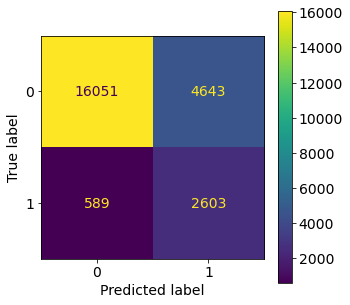

In [368]:
plt.rcParams.update({'figure.figsize': (5.0, 5)})
print(classification_report(y_valid, y_pred_rf))
plot_confusion_matrix(clf, X_valid, y_valid)


In [155]:
FP = confusion_matrix(y_valid, y_pred_rf)[0][1]
TP = confusion_matrix(y_valid, y_pred_rf)[1][1]
FN = confusion_matrix(y_valid, y_pred_rf)[1][0]
TN = confusion_matrix(y_valid, y_pred_rf)[1][1]

In [201]:
# False Positive Rate: When it predicts over 50k, how often is it actually under 50k? When does it falsely assign the positive class?
FPR = FP/(FP+FN) 
print(f"Our model's False Positive Rate is {FPR}, meaning that the model is very good at predicting over 50k when it is actually over 50k")

# False Negative Rate: of all the ones that are actually over 50k, how many were predicted under 50k? Again, when does it falsely assign the positive class
FNR = FN/(FN+TP)
print(f"Our model's False Negative Rate is {FNR}, meaning that the model doesn't predict under 50k when it's actually over 50k very often")

# True Positive Rate/Recall: How many over 50k's were caught by the model, and how many 'slipped through'?
TPR = TP/(FN+TP)
# Cons: Doesn't take False Positive into account 
print(f"Our model's True Positive Rate is {TPR}, meaning that most over 50k's are caught")


# True Negative Rate: When it predicts under 50k, how often is it under over 50k? - how many negatives were falsely assigned positives 
TNR = TN/(TN+FP)
print(f"Our model's True Negative Rate is {TPR}, meaning that around 35% of our negatives are falsely assigned positives")

# Precision: Of all the ones predicted over 50k, how many are actually over 50k 
Precision = TP/(TP+FP) 
# Cons: Doesn't take false negative into account 
print(f"Our model's Precision is {Precision}, meaning that only about 35% of the predicted positives are actually positive ")


# Our problem: Our False Positives are very high, meaning that the model predicts a lot of people to have over 50k when in reality they do not. 

Our model's False Positive Rate is 0.8871521158978269, meaning that the model is very good at predicting over 50k when it is actually over 50k
Our model's False Negative Rate is 0.18546365914786966, meaning that the model doesn't predict under 50k when it's actually over 50k very often
Our model's True Positive Rate is 0.8145363408521303, meaning that most over 50k's are caught
Our model's True Negative Rate is 0.8145363408521303, meaning that around 35% of our negatives are falsely assigned positives
Our model's Precision is 0.35842293906810035, meaning that only about 35% of the predicted positives are actually positive 


* Want to decrease our false positives

In [257]:
# Cross Validation
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)

[0.78937681 0.78806206 0.79805417 0.7793847  0.78984745]


scores - not much of a difference

In [103]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.96      0.77      0.86     30889
           1       0.36      0.81      0.49      4763

    accuracy                           0.78     35652
   macro avg       0.66      0.79      0.68     35652
weighted avg       0.88      0.78      0.81     35652

              precision    recall  f1-score   support

           0       0.96      0.79      0.87     30889
           1       0.37      0.81      0.50      4763

    accuracy                           0.79     35652
   macro avg       0.67      0.80      0.68     35652
weighted avg       0.88      0.79      0.82     35652



In [244]:
# How could we improve false positives?
# In the future, could try some anomoly detection, since the positive class is over 5% of the data, 
# we can use isolation forest (if it was very small we would want to use outlier detection) - but I am unsure if there are any features that could really
# make this that effective

test.data.income.value_counts()
test.data.groupby('income').count()['index'].apply(lambda x: f"{round(x/test.data.shape[0]*100, 2)}%")
# Since the positive class is over 5% of the data, we can use isolation forest (if it was very small we would want to use outlier detection)

income
0    86.64%
1    13.36%
Name: index, dtype: object

# Tuning Model

In [248]:
n_estimators = [500, 800, 1500, 2500, 5000]
max_features = ['audio', 'sqrt', 'log2']
max_depth = [10,20,30,40,50]
min_samples_split = [2,5,10,15,20]
min_samples_leaf = [1,2,5,10,15]

grid_param = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

In [252]:
# from sklearn.model_selection import RandomizedSearchCV
# rfc = RandomForestClassifier()
# rfr_random = RandomizedSearchCV(estimator=rfc,
#                                param_distributions = grid_param,
#                                n_iter = 500,
#                                cv = 5,
#                                verbose = 2, n_jobs=-1)

# rfc_random.fit(X_train, y_train)
# print(rfr_random.best_params)

# Testing Data

              precision    recall  f1-score   support

           0       0.96      0.77      0.85     10195
           1       0.35      0.81      0.49      1571

    accuracy                           0.77     11766
   macro avg       0.66      0.79      0.67     11766
weighted avg       0.88      0.77      0.81     11766



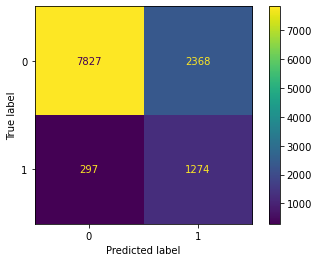

In [262]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
plot_confusion_matrix(clf, X_test, y_test)


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.49')

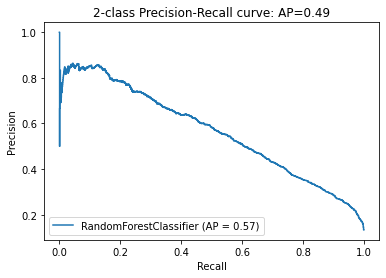

In [263]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

# Feature Importance

Text(0.5, 0, 'Random Forest Feature Importance')

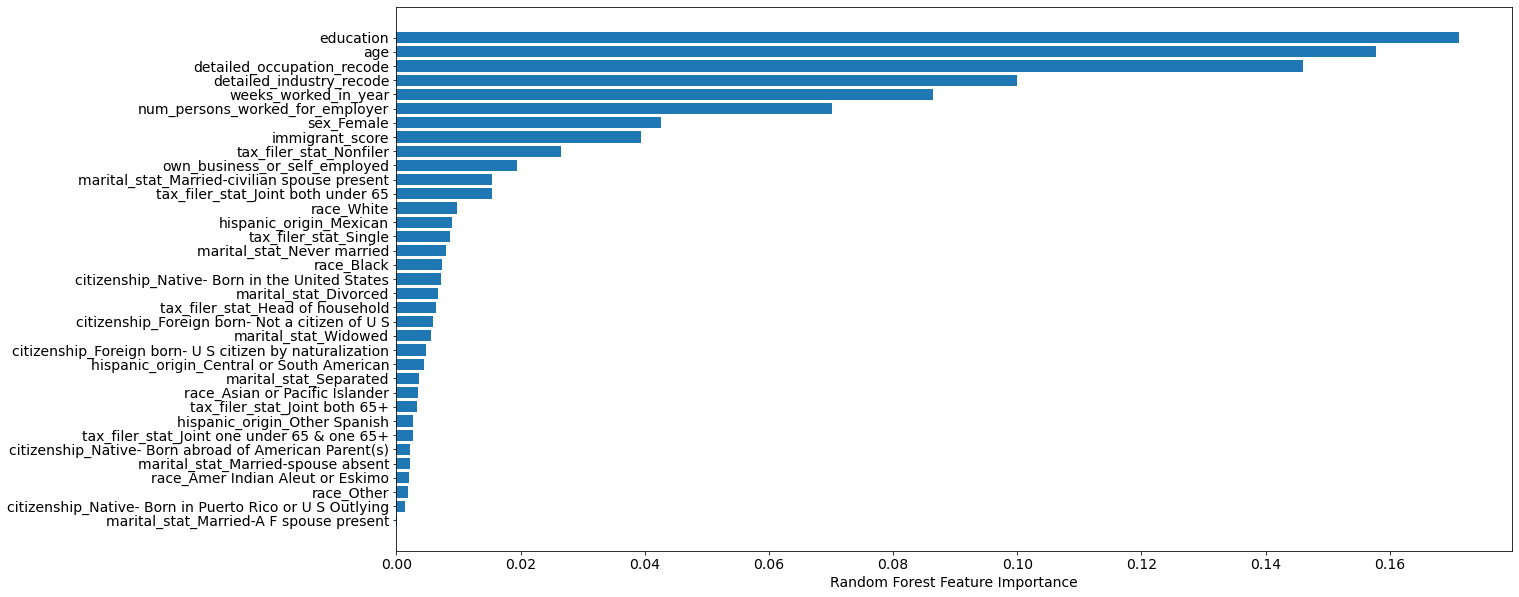

In [438]:
plt.figure(figsize=(20,10))
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")


In [441]:
X_train['income']=y_train
X_train.corr()['sex_Female']
X_train.corr().loc[['age', 'education', 'sex_Female', 'immigrant_score', 'num_persons_worked_for_employer', 'weeks_worked_in_year', 'race_White', 'hispanic_origin_Mexican']][['income']]

,income
age,-0.006709
education,0.478045
sex_Female,-0.290425
immigrant_score,0.071884
num_persons_worked_for_employer,0.271289
weeks_worked_in_year,0.358084
race_White,0.116060
hispanic_origin_Mexican,-0.114524


[Text(558.0, 906.0, 'num_persons_worked_for_employer <= 0.5\nentropy = 1.0\nsamples = 12010\nvalue = [9493, 9521]'),
 Text(279.0, 543.6, 'marital_stat_Married-civilian spouse present <= 0.5\nentropy = 0.614\nsamples = 1846\nvalue = [2472, 442]'),
 Text(139.5, 181.19999999999993, 'entropy = 0.466\nsamples = 1120\nvalue = [1553, 171]'),
 Text(418.5, 181.19999999999993, 'entropy = 0.774\nsamples = 726\nvalue = [919, 271]'),
 Text(837.0, 543.6, 'num_persons_worked_for_employer <= 5.5\nentropy = 0.988\nsamples = 10164\nvalue = [7021, 9079]'),
 Text(697.5, 181.19999999999993, 'entropy = 0.999\nsamples = 5923\nvalue = [4575, 4841]'),
 Text(976.5, 181.19999999999993, 'entropy = 0.948\nsamples = 4241\nvalue = [2446, 4238]')]

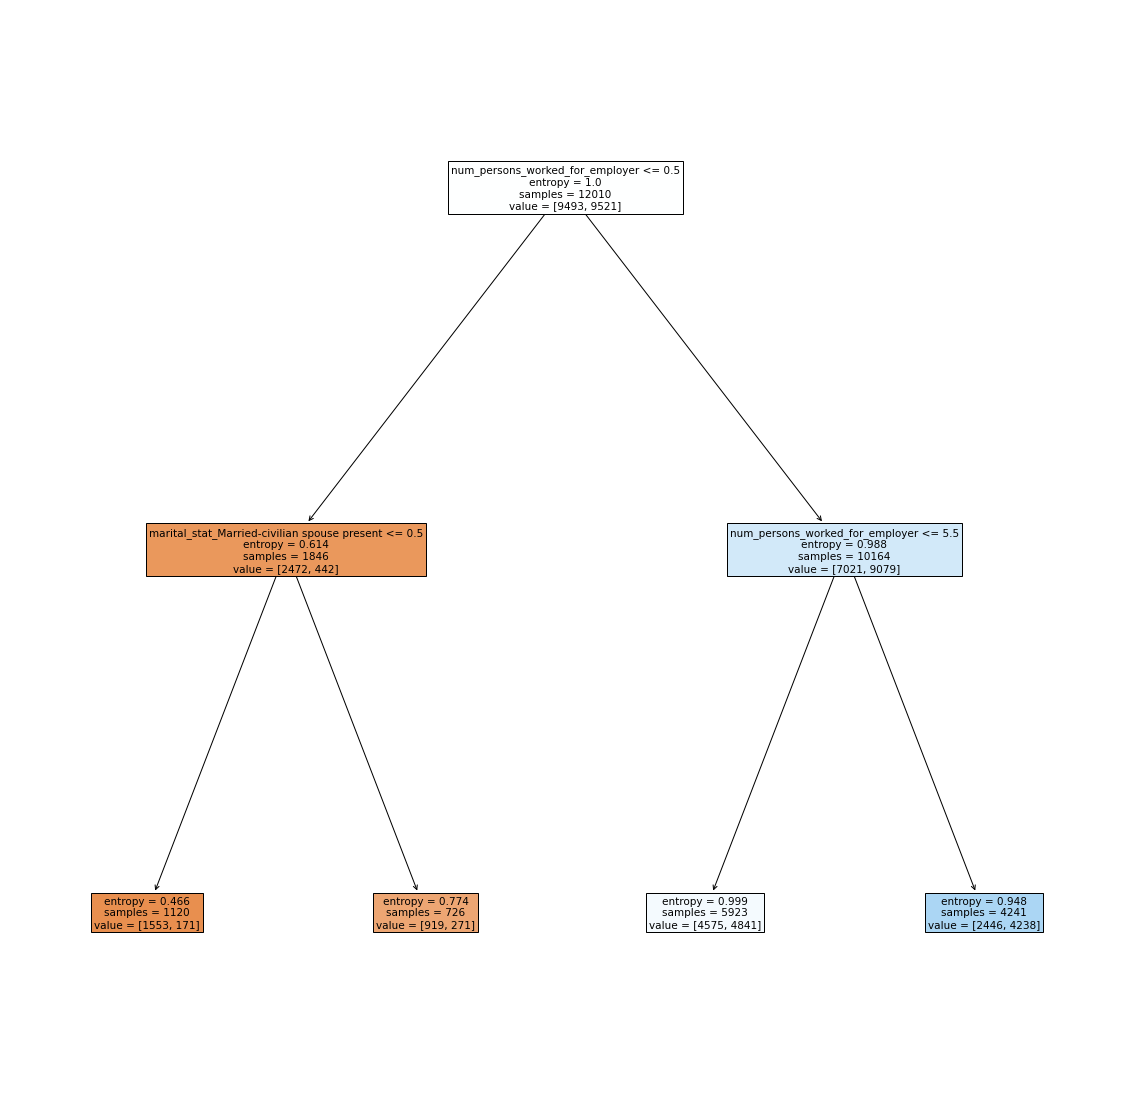

In [363]:
# from sklearn import tree
plt.rcParams.update({'figure.figsize': (20.0, 20)})
plt.rcParams.update({'font.size': 14})
clf_visualization = RandomForestClassifier(max_depth=2, random_state=0, min_samples_split=2, criterion='entropy')
clf_visualization.fit(X_train, y_train)
tree.plot_tree(clf_visualization.estimators_[0], feature_names=X_train.columns, filled=True)